## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

## Load Cifar-10 Dataset

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Custom functions

1) custom function for batch normalization:

In [3]:
# a simpler wrapper function for batch normalization
# inputs should be two-dimensional
# with the first dim normalized
def batch_norm_wrapper(inputs, is_training, decay = 0.999):
    epsilon = 1e-6

    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training is True:
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        train_mean = tf.assign(pop_mean,
                               pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,
                              pop_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)

2) define a custom solver function:

In [4]:
def run_model(session, predict, mean_loss, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, r=0.0):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         reg: r,
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

## Model 1: reduced filter sizes

[conv-bn-relu-pool]x2->[affine-bn-relu]->affine

### Developing a computational graph:

1) developing computational graphs using tensorflow layer functions

2) define **cross-entropy loss** function, **optimizer**

In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)
reg = tf.placeholder(tf.float32, [])

def model_two(X, y, reg, is_training):
    # define variables
    # conv layer without padding
    Wconv1 = tf.get_variable('Wconv1', shape=[5, 5, 3, 32])
    bconv1 = tf.get_variable('bconv1', shape=[32])
    # conv 2 with padding
    Wconv2 = tf.get_variable('Wconv2', shape=[3, 3, 32, 64])
    bconv2 = tf.get_variable('bconv2', shape=[64])
    # affine one
    W1 = tf.get_variable('W1', shape=[4096, 1024])
    b1 = tf.get_variable('b1', shape=[1024])
    # affine two
    W2 = tf.get_variable('W2', shape=[1024, 10])
    b2 = tf.get_variable('b2', shape=[10])

    # define computer graph
    # conv-bn-relu-maxpooling
    h1_conv = tf.nn.conv2d(X, Wconv1, strides=[1,1,1,1], padding='SAME') + bconv1
    # for reshape, there should 32 classes after conv layer
    h1_bn = batch_norm_wrapper(tf.reshape(h1_conv, [-1, 32]), is_training)
    h1_bn = tf.reshape(h1_bn, [-1, 32, 32, 32])
    h1_relu = tf.nn.relu(h1_bn)
    # image_size = 16 after max pooling
    h1_pool = tf.layers.max_pooling2d(h1_relu, pool_size=[2,2], strides=(2,2), padding='valid')
    
    # conv-bn-relu-maxpooling
    h2_conv = tf.nn.conv2d(h1_pool, Wconv2, strides=[1,1,1,1], padding='SAME') + bconv2
    h2_bn = batch_norm_wrapper(tf.reshape(h2_conv, [-1, 64]), is_training)
    h2_bn = tf.reshape(h2_bn, [-1, 32, 32, 64])
    h2_relu = tf.nn.relu(h2_bn)
    # image_size = 8 after max pooling
    h2_pool = tf.layers.max_pooling2d(h2_relu, pool_size=[2,2], strides=(2,2), padding='valid')
    
    # affine-bn-relu
    h2_flat = tf.reshape(h2_pool, [-1, 4096])
    h3_affine = tf.matmul(h2_flat, W1) + b1
    h3_bn = batch_norm_wrapper(h3_affine, is_training)
    h3_relu = tf.nn.relu(h3_bn)
    
    # affine output layer
    y_out = tf.matmul(h3_relu, W2) + b2

    # loss 
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
    mean_loss = tf.reduce_mean(total_loss)
    reg_loss = tf.nn.l2_loss(Wconv1) + tf.nn.l2_loss(Wconv2) + \
               tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    mean_loss = tf.reduce_mean(mean_loss + reg * reg_loss)

    return y_out, mean_loss

y_out, mean_loss = model_two(X,y,reg,is_training)


# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

3) implementation check dimension is right?

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32, 3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 3.85 ms per loop
(64, 10)
True


5) train the model with 10 epoch:

Training
Iteration 0: with minibatch training loss = 40.4 and accuracy of 0.12
Iteration 100: with minibatch training loss = 3.42 and accuracy of 0.36
Iteration 200: with minibatch training loss = 3.5 and accuracy of 0.27
Iteration 300: with minibatch training loss = 1.86 and accuracy of 0.41
Iteration 400: with minibatch training loss = 1.74 and accuracy of 0.44
Iteration 500: with minibatch training loss = 1.74 and accuracy of 0.55
Iteration 600: with minibatch training loss = 1.81 and accuracy of 0.41
Iteration 700: with minibatch training loss = 1.56 and accuracy of 0.52
Epoch 1, Overall loss = 2.88 and accuracy of 0.398


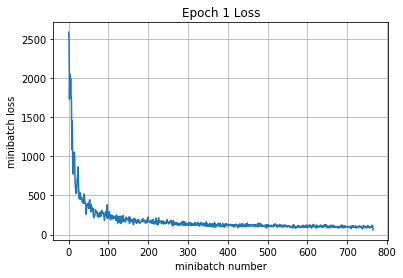

Iteration 800: with minibatch training loss = 1.38 and accuracy of 0.5
Iteration 900: with minibatch training loss = 1.15 and accuracy of 0.64
Iteration 1000: with minibatch training loss = 1.31 and accuracy of 0.59
Iteration 1100: with minibatch training loss = 1.3 and accuracy of 0.52
Iteration 1200: with minibatch training loss = 1.2 and accuracy of 0.61
Iteration 1300: with minibatch training loss = 1.3 and accuracy of 0.5
Iteration 1400: with minibatch training loss = 1.25 and accuracy of 0.48
Iteration 1500: with minibatch training loss = 1.05 and accuracy of 0.56
Epoch 2, Overall loss = 1.27 and accuracy of 0.563


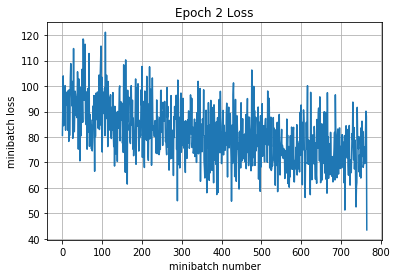

Iteration 1600: with minibatch training loss = 0.953 and accuracy of 0.56
Iteration 1700: with minibatch training loss = 1.01 and accuracy of 0.66
Iteration 1800: with minibatch training loss = 0.751 and accuracy of 0.78
Iteration 1900: with minibatch training loss = 0.883 and accuracy of 0.7
Iteration 2000: with minibatch training loss = 0.804 and accuracy of 0.77
Iteration 2100: with minibatch training loss = 0.796 and accuracy of 0.75
Iteration 2200: with minibatch training loss = 0.959 and accuracy of 0.64
Epoch 3, Overall loss = 0.958 and accuracy of 0.672


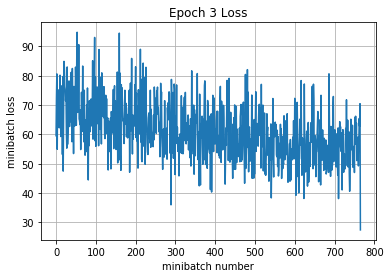

Iteration 2300: with minibatch training loss = 0.943 and accuracy of 0.66
Iteration 2400: with minibatch training loss = 0.789 and accuracy of 0.69
Iteration 2500: with minibatch training loss = 0.888 and accuracy of 0.7
Iteration 2600: with minibatch training loss = 0.701 and accuracy of 0.78
Iteration 2700: with minibatch training loss = 0.656 and accuracy of 0.8
Iteration 2800: with minibatch training loss = 0.84 and accuracy of 0.69
Iteration 2900: with minibatch training loss = 0.701 and accuracy of 0.83
Iteration 3000: with minibatch training loss = 0.532 and accuracy of 0.78
Epoch 4, Overall loss = 0.689 and accuracy of 0.772


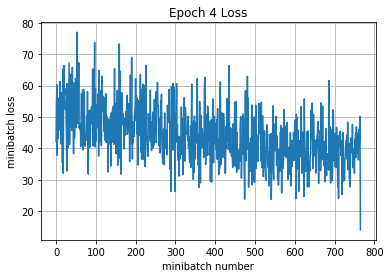

Iteration 3100: with minibatch training loss = 0.427 and accuracy of 0.91
Iteration 3200: with minibatch training loss = 0.364 and accuracy of 0.94
Iteration 3300: with minibatch training loss = 0.417 and accuracy of 0.89
Iteration 3400: with minibatch training loss = 0.373 and accuracy of 0.92
Iteration 3500: with minibatch training loss = 0.345 and accuracy of 0.88
Iteration 3600: with minibatch training loss = 0.354 and accuracy of 0.89
Iteration 3700: with minibatch training loss = 0.376 and accuracy of 0.91
Iteration 3800: with minibatch training loss = 0.369 and accuracy of 0.92
Epoch 5, Overall loss = 0.438 and accuracy of 0.868


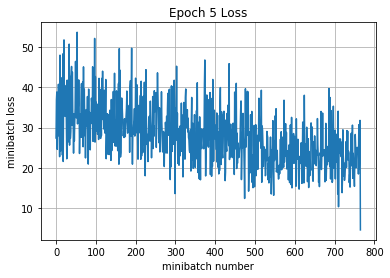

Iteration 3900: with minibatch training loss = 0.231 and accuracy of 0.95
Iteration 4000: with minibatch training loss = 0.227 and accuracy of 0.94
Iteration 4100: with minibatch training loss = 0.198 and accuracy of 0.98
Iteration 4200: with minibatch training loss = 0.286 and accuracy of 0.92
Iteration 4300: with minibatch training loss = 0.288 and accuracy of 0.92
Iteration 4400: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 4500: with minibatch training loss = 0.296 and accuracy of 0.91
Epoch 6, Overall loss = 0.254 and accuracy of 0.935


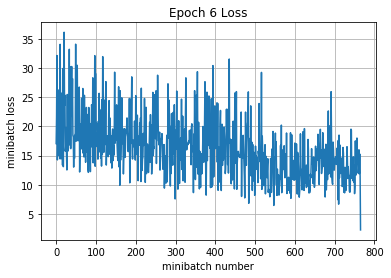

Iteration 4600: with minibatch training loss = 0.136 and accuracy of 0.97
Iteration 4700: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 4800: with minibatch training loss = 0.209 and accuracy of 0.94
Iteration 4900: with minibatch training loss = 0.22 and accuracy of 0.95
Iteration 5000: with minibatch training loss = 0.302 and accuracy of 0.92
Iteration 5100: with minibatch training loss = 0.203 and accuracy of 0.91
Iteration 5200: with minibatch training loss = 0.181 and accuracy of 0.98
Iteration 5300: with minibatch training loss = 0.186 and accuracy of 0.97
Epoch 7, Overall loss = 0.186 and accuracy of 0.949


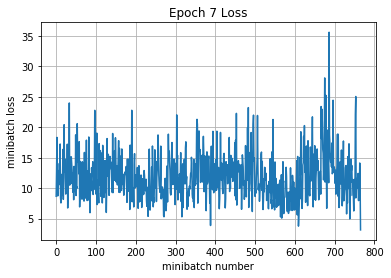

Iteration 5400: with minibatch training loss = 0.176 and accuracy of 0.95
Iteration 5500: with minibatch training loss = 0.139 and accuracy of 0.97
Iteration 5600: with minibatch training loss = 0.143 and accuracy of 0.97
Iteration 5700: with minibatch training loss = 0.147 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.232 and accuracy of 0.94
Iteration 5900: with minibatch training loss = 0.0755 and accuracy of 0.98
Iteration 6000: with minibatch training loss = 0.146 and accuracy of 0.94
Iteration 6100: with minibatch training loss = 0.131 and accuracy of 0.98
Epoch 8, Overall loss = 0.181 and accuracy of 0.944


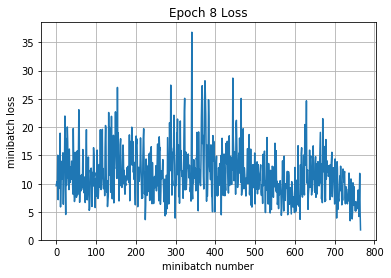

Iteration 6200: with minibatch training loss = 0.114 and accuracy of 0.97
Iteration 6300: with minibatch training loss = 0.139 and accuracy of 0.95
Iteration 6400: with minibatch training loss = 0.0997 and accuracy of 0.97
Iteration 6500: with minibatch training loss = 0.121 and accuracy of 0.98
Iteration 6600: with minibatch training loss = 0.121 and accuracy of 0.97
Iteration 6700: with minibatch training loss = 0.105 and accuracy of 0.94
Iteration 6800: with minibatch training loss = 0.0787 and accuracy of 1
Epoch 9, Overall loss = 0.138 and accuracy of 0.958


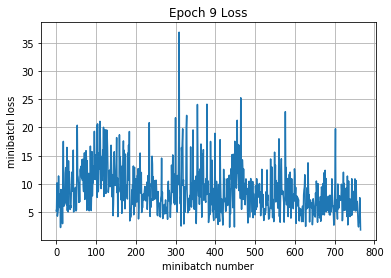

Iteration 6900: with minibatch training loss = 0.156 and accuracy of 0.91
Iteration 7000: with minibatch training loss = 0.217 and accuracy of 0.91
Iteration 7100: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 7200: with minibatch training loss = 0.0615 and accuracy of 0.98
Iteration 7300: with minibatch training loss = 0.0751 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.071 and accuracy of 1
Iteration 7500: with minibatch training loss = 0.0669 and accuracy of 0.98
Iteration 7600: with minibatch training loss = 0.127 and accuracy of 0.98
Epoch 10, Overall loss = 0.104 and accuracy of 0.97


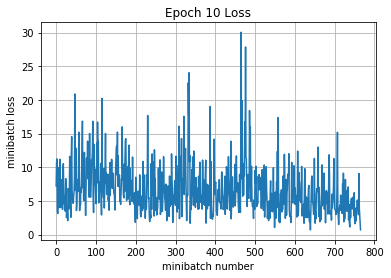

Training net accurary
Epoch 1, Overall loss = 0.0958 and accuracy of 0.97
Validation
Epoch 1, Overall loss = 1.59 and accuracy of 0.636


In [7]:
with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)
        print('Training net accurary')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Model 2: Model 1 with Regularization

Add regularization to all weights in the cnn architecture. Maybe also dropout as an effective way of regularization.

1) train the model 1 with `reg = 0.05`:

Training
Iteration 0: with minibatch training loss = 81.6 and accuracy of 0.078
Iteration 100: with minibatch training loss = 42.8 and accuracy of 0.39
Iteration 200: with minibatch training loss = 39.7 and accuracy of 0.28
Iteration 300: with minibatch training loss = 36.4 and accuracy of 0.44
Iteration 400: with minibatch training loss = 34.2 and accuracy of 0.36
Iteration 500: with minibatch training loss = 31.5 and accuracy of 0.48
Iteration 600: with minibatch training loss = 29.7 and accuracy of 0.5
Iteration 700: with minibatch training loss = 27.8 and accuracy of 0.56
Epoch 1, Overall loss = 35.9 and accuracy of 0.398


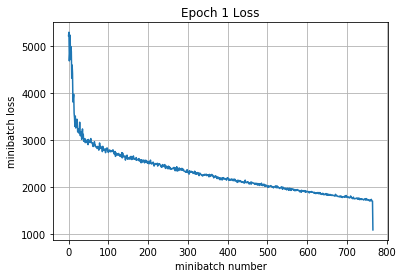

Iteration 800: with minibatch training loss = 26.2 and accuracy of 0.44
Iteration 900: with minibatch training loss = 24.6 and accuracy of 0.56
Iteration 1000: with minibatch training loss = 23.1 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 21.4 and accuracy of 0.59
Iteration 1200: with minibatch training loss = 20.3 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 19.3 and accuracy of 0.53
Iteration 1400: with minibatch training loss = 18 and accuracy of 0.58
Iteration 1500: with minibatch training loss = 17 and accuracy of 0.64
Epoch 2, Overall loss = 21.3 and accuracy of 0.566


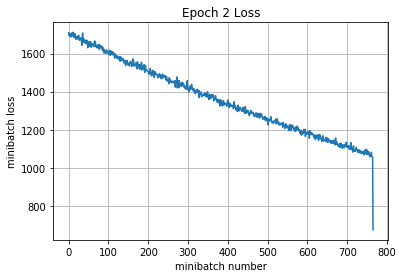

Iteration 1600: with minibatch training loss = 15.9 and accuracy of 0.61
Iteration 1700: with minibatch training loss = 15 and accuracy of 0.56
Iteration 1800: with minibatch training loss = 13.8 and accuracy of 0.72
Iteration 1900: with minibatch training loss = 13.2 and accuracy of 0.62
Iteration 2000: with minibatch training loss = 12.3 and accuracy of 0.72
Iteration 2100: with minibatch training loss = 11.5 and accuracy of 0.72
Iteration 2200: with minibatch training loss = 11 and accuracy of 0.62
Epoch 3, Overall loss = 13.2 and accuracy of 0.65


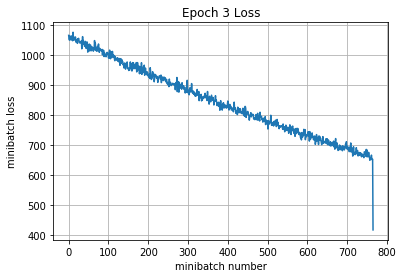

Iteration 2300: with minibatch training loss = 10.1 and accuracy of 0.77
Iteration 2400: with minibatch training loss = 9.76 and accuracy of 0.58
Iteration 2500: with minibatch training loss = 8.91 and accuracy of 0.78
Iteration 2600: with minibatch training loss = 8.56 and accuracy of 0.66
Iteration 2700: with minibatch training loss = 7.92 and accuracy of 0.72
Iteration 2800: with minibatch training loss = 7.49 and accuracy of 0.78
Iteration 2900: with minibatch training loss = 7.23 and accuracy of 0.67
Iteration 3000: with minibatch training loss = 6.61 and accuracy of 0.75
Epoch 4, Overall loss = 8.16 and accuracy of 0.697


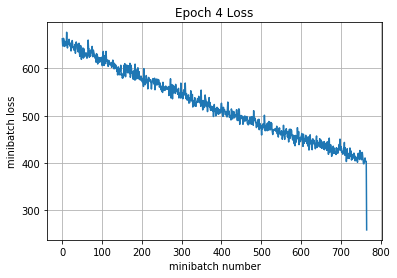

Iteration 3100: with minibatch training loss = 6.34 and accuracy of 0.75
Iteration 3200: with minibatch training loss = 5.84 and accuracy of 0.66
Iteration 3300: with minibatch training loss = 5.56 and accuracy of 0.7
Iteration 3400: with minibatch training loss = 5.02 and accuracy of 0.78
Iteration 3500: with minibatch training loss = 4.91 and accuracy of 0.73
Iteration 3600: with minibatch training loss = 4.62 and accuracy of 0.72
Iteration 3700: with minibatch training loss = 4.22 and accuracy of 0.81
Iteration 3800: with minibatch training loss = 4.01 and accuracy of 0.83
Epoch 5, Overall loss = 5.12 and accuracy of 0.723


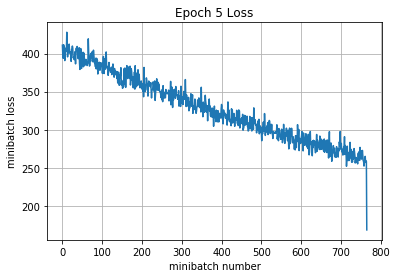

Iteration 3900: with minibatch training loss = 4.08 and accuracy of 0.73
Iteration 4000: with minibatch training loss = 4.03 and accuracy of 0.66
Iteration 4100: with minibatch training loss = 3.59 and accuracy of 0.75
Iteration 4200: with minibatch training loss = 3.29 and accuracy of 0.8
Iteration 4300: with minibatch training loss = 3.24 and accuracy of 0.75
Iteration 4400: with minibatch training loss = 3.16 and accuracy of 0.69
Iteration 4500: with minibatch training loss = 3.05 and accuracy of 0.7
Epoch 6, Overall loss = 3.41 and accuracy of 0.74


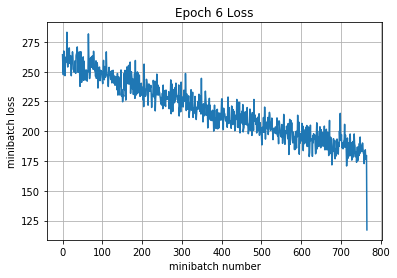

Iteration 4600: with minibatch training loss = 2.92 and accuracy of 0.67
Iteration 4700: with minibatch training loss = 2.73 and accuracy of 0.73
Iteration 4800: with minibatch training loss = 2.46 and accuracy of 0.84
Iteration 4900: with minibatch training loss = 2.51 and accuracy of 0.72
Iteration 5000: with minibatch training loss = 2.29 and accuracy of 0.78
Iteration 5100: with minibatch training loss = 2.35 and accuracy of 0.75
Iteration 5200: with minibatch training loss = 2.49 and accuracy of 0.62
Iteration 5300: with minibatch training loss = 2.27 and accuracy of 0.72
Epoch 7, Overall loss = 2.5 and accuracy of 0.75


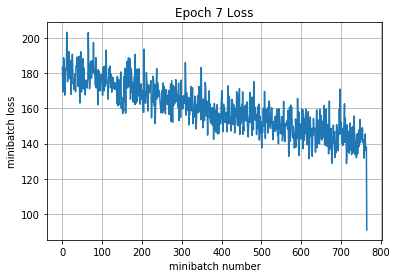

Iteration 5400: with minibatch training loss = 2.3 and accuracy of 0.73
Iteration 5500: with minibatch training loss = 2.23 and accuracy of 0.67
Iteration 5600: with minibatch training loss = 2.08 and accuracy of 0.75
Iteration 5700: with minibatch training loss = 2.06 and accuracy of 0.77
Iteration 5800: with minibatch training loss = 2.21 and accuracy of 0.67
Iteration 5900: with minibatch training loss = 2.01 and accuracy of 0.7
Iteration 6000: with minibatch training loss = 1.96 and accuracy of 0.73
Iteration 6100: with minibatch training loss = 1.86 and accuracy of 0.81
Epoch 8, Overall loss = 2.03 and accuracy of 0.758


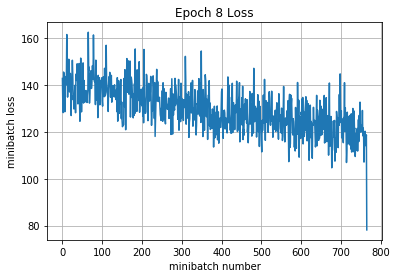

Iteration 6200: with minibatch training loss = 1.99 and accuracy of 0.73
Iteration 6300: with minibatch training loss = 1.88 and accuracy of 0.75
Iteration 6400: with minibatch training loss = 1.84 and accuracy of 0.8
Iteration 6500: with minibatch training loss = 1.62 and accuracy of 0.78
Iteration 6600: with minibatch training loss = 1.71 and accuracy of 0.72
Iteration 6700: with minibatch training loss = 1.55 and accuracy of 0.84
Iteration 6800: with minibatch training loss = 1.6 and accuracy of 0.8
Epoch 9, Overall loss = 1.76 and accuracy of 0.765


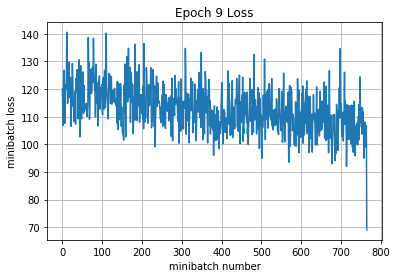

Iteration 6900: with minibatch training loss = 1.49 and accuracy of 0.86
Iteration 7000: with minibatch training loss = 1.73 and accuracy of 0.73
Iteration 7100: with minibatch training loss = 1.67 and accuracy of 0.73
Iteration 7200: with minibatch training loss = 1.66 and accuracy of 0.8
Iteration 7300: with minibatch training loss = 1.56 and accuracy of 0.73
Iteration 7400: with minibatch training loss = 1.54 and accuracy of 0.78
Iteration 7500: with minibatch training loss = 1.64 and accuracy of 0.73
Iteration 7600: with minibatch training loss = 1.46 and accuracy of 0.81
Epoch 10, Overall loss = 1.6 and accuracy of 0.773


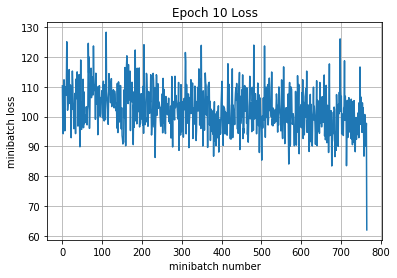

Iteration 7700: with minibatch training loss = 1.44 and accuracy of 0.81
Iteration 7800: with minibatch training loss = 1.34 and accuracy of 0.86
Iteration 7900: with minibatch training loss = 1.63 and accuracy of 0.7
Iteration 8000: with minibatch training loss = 1.59 and accuracy of 0.8
Iteration 8100: with minibatch training loss = 1.4 and accuracy of 0.83
Iteration 8200: with minibatch training loss = 1.47 and accuracy of 0.81
Iteration 8300: with minibatch training loss = 1.31 and accuracy of 0.86
Iteration 8400: with minibatch training loss = 1.4 and accuracy of 0.83
Epoch 11, Overall loss = 1.49 and accuracy of 0.782


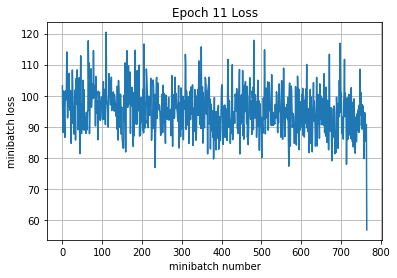

Iteration 8500: with minibatch training loss = 1.46 and accuracy of 0.77
Iteration 8600: with minibatch training loss = 1.4 and accuracy of 0.75
Iteration 8700: with minibatch training loss = 1.36 and accuracy of 0.81
Iteration 8800: with minibatch training loss = 1.45 and accuracy of 0.75
Iteration 8900: with minibatch training loss = 1.41 and accuracy of 0.77
Iteration 9000: with minibatch training loss = 1.52 and accuracy of 0.77
Iteration 9100: with minibatch training loss = 1.28 and accuracy of 0.83
Epoch 12, Overall loss = 1.41 and accuracy of 0.792


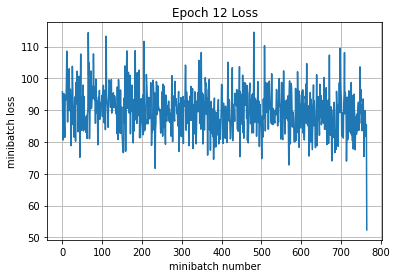

Iteration 9200: with minibatch training loss = 1.4 and accuracy of 0.78
Iteration 9300: with minibatch training loss = 1.24 and accuracy of 0.88
Iteration 9400: with minibatch training loss = 1.24 and accuracy of 0.86
Iteration 9500: with minibatch training loss = 1.34 and accuracy of 0.8
Iteration 9600: with minibatch training loss = 1.36 and accuracy of 0.72
Iteration 9700: with minibatch training loss = 1.63 and accuracy of 0.72
Iteration 9800: with minibatch training loss = 1.21 and accuracy of 0.83
Iteration 9900: with minibatch training loss = 1.44 and accuracy of 0.78
Epoch 13, Overall loss = 1.34 and accuracy of 0.8


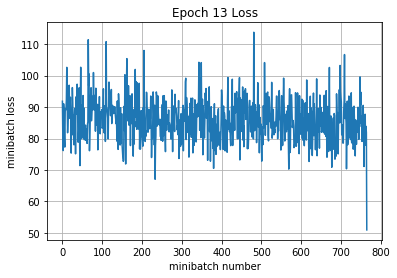

Iteration 10000: with minibatch training loss = 1.45 and accuracy of 0.78
Iteration 10100: with minibatch training loss = 1.38 and accuracy of 0.84
Iteration 10200: with minibatch training loss = 1.28 and accuracy of 0.84
Iteration 10300: with minibatch training loss = 1.37 and accuracy of 0.84
Iteration 10400: with minibatch training loss = 1.17 and accuracy of 0.83
Iteration 10500: with minibatch training loss = 1.29 and accuracy of 0.83
Iteration 10600: with minibatch training loss = 1.32 and accuracy of 0.8
Iteration 10700: with minibatch training loss = 1.21 and accuracy of 0.88
Epoch 14, Overall loss = 1.29 and accuracy of 0.81


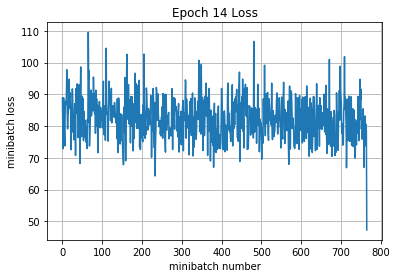

Iteration 10800: with minibatch training loss = 1.36 and accuracy of 0.83
Iteration 10900: with minibatch training loss = 1.22 and accuracy of 0.83
Iteration 11000: with minibatch training loss = 1.24 and accuracy of 0.8
Iteration 11100: with minibatch training loss = 1.16 and accuracy of 0.86
Iteration 11200: with minibatch training loss = 1.16 and accuracy of 0.86
Iteration 11300: with minibatch training loss = 1.33 and accuracy of 0.78
Iteration 11400: with minibatch training loss = 1.2 and accuracy of 0.78
Epoch 15, Overall loss = 1.24 and accuracy of 0.82


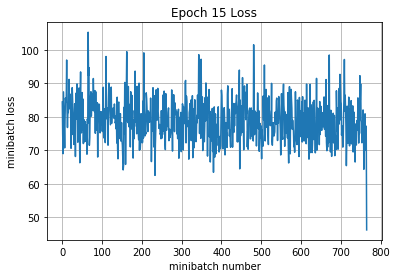

Iteration 11500: with minibatch training loss = 1.29 and accuracy of 0.83
Iteration 11600: with minibatch training loss = 1.47 and accuracy of 0.7
Iteration 11700: with minibatch training loss = 1.12 and accuracy of 0.84
Iteration 11800: with minibatch training loss = 1.35 and accuracy of 0.78
Iteration 11900: with minibatch training loss = 1.16 and accuracy of 0.83
Iteration 12000: with minibatch training loss = 1.11 and accuracy of 0.84
Iteration 12100: with minibatch training loss = 1.24 and accuracy of 0.84
Iteration 12200: with minibatch training loss = 1.24 and accuracy of 0.77
Epoch 16, Overall loss = 1.19 and accuracy of 0.83


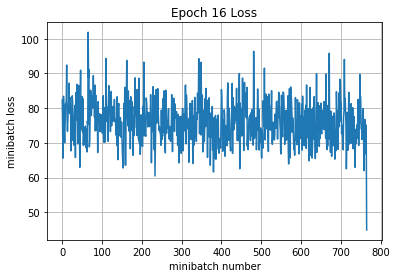

Iteration 12300: with minibatch training loss = 0.955 and accuracy of 0.95
Iteration 12400: with minibatch training loss = 1.09 and accuracy of 0.89
Iteration 12500: with minibatch training loss = 1.13 and accuracy of 0.84
Iteration 12600: with minibatch training loss = 1.33 and accuracy of 0.75
Iteration 12700: with minibatch training loss = 1.25 and accuracy of 0.8
Iteration 12800: with minibatch training loss = 1.3 and accuracy of 0.77
Iteration 12900: with minibatch training loss = 1.1 and accuracy of 0.86
Iteration 13000: with minibatch training loss = 1.22 and accuracy of 0.83
Epoch 17, Overall loss = 1.15 and accuracy of 0.839


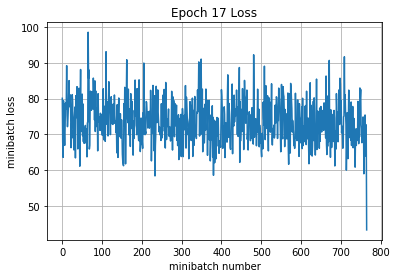

Iteration 13100: with minibatch training loss = 1.27 and accuracy of 0.8
Iteration 13200: with minibatch training loss = 0.969 and accuracy of 0.91
Iteration 13300: with minibatch training loss = 1.22 and accuracy of 0.83
Iteration 13400: with minibatch training loss = 0.976 and accuracy of 0.92
Iteration 13500: with minibatch training loss = 1.08 and accuracy of 0.89
Iteration 13600: with minibatch training loss = 1.05 and accuracy of 0.91
Iteration 13700: with minibatch training loss = 1.09 and accuracy of 0.84
Epoch 18, Overall loss = 1.12 and accuracy of 0.848


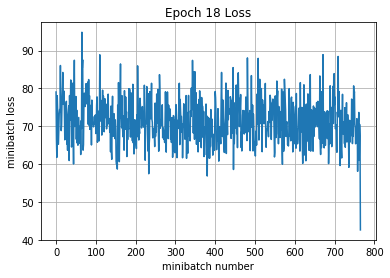

Iteration 13800: with minibatch training loss = 1.12 and accuracy of 0.86
Iteration 13900: with minibatch training loss = 1.09 and accuracy of 0.84
Iteration 14000: with minibatch training loss = 1.17 and accuracy of 0.84
Iteration 14100: with minibatch training loss = 1.18 and accuracy of 0.84
Iteration 14200: with minibatch training loss = 1.05 and accuracy of 0.89
Iteration 14300: with minibatch training loss = 1.24 and accuracy of 0.77
Iteration 14400: with minibatch training loss = 1.12 and accuracy of 0.81
Iteration 14500: with minibatch training loss = 1.13 and accuracy of 0.84
Epoch 19, Overall loss = 1.09 and accuracy of 0.856


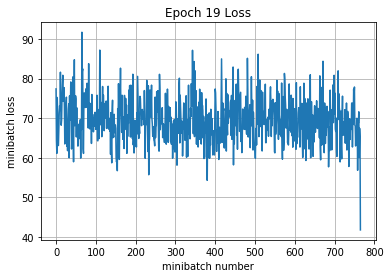

Iteration 14600: with minibatch training loss = 1.25 and accuracy of 0.81
Iteration 14700: with minibatch training loss = 1.08 and accuracy of 0.84
Iteration 14800: with minibatch training loss = 0.972 and accuracy of 0.91
Iteration 14900: with minibatch training loss = 1.19 and accuracy of 0.81
Iteration 15000: with minibatch training loss = 0.868 and accuracy of 0.95
Iteration 15100: with minibatch training loss = 1.12 and accuracy of 0.78
Iteration 15200: with minibatch training loss = 0.939 and accuracy of 0.91
Iteration 15300: with minibatch training loss = 1.08 and accuracy of 0.86
Epoch 20, Overall loss = 1.06 and accuracy of 0.864


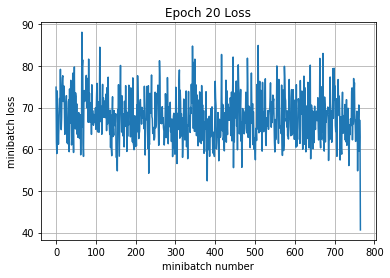

Training net accurary
Epoch 1, Overall loss = 0.439 and accuracy of 0.85
Validation
Epoch 1, Overall loss = 0.873 and accuracy of 0.71


In [10]:
with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,20,64,100,train_step,True,0.05)
        print('Training net accurary')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Conclusion:

- I was only able to reach a validation accuracy of 0.71 after the global regularization term is added.
- There is a problem with the implementation of batch-normalization here, due to the fact that the name scope of each normalization layers is not well-defined.
- In principle, with the batch-norm correctly implemented, one can easily boost the prediction accuracy to above 0.8, and the correct version will be implemented later.